In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd '/content/drive/MyDrive/Deep_learning'

/content/drive/MyDrive/Deep_learning


In [3]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import torchvision
from torchvision import transforms
from torchvision import datasets
import numpy as np
import matplotlib.pyplot as plt
from pytorchcv import train, plot_results

In [4]:
class Residual(nn.Module):
    def __init__(self, num_channels, use_1x1conv = False, strides = 1):
        super().__init__()
        self.conv1 = nn.LazyConv2d(num_channels, kernel_size = 3, padding = 1, stride = strides)
        self.conv2 = nn.LazyConv2d(num_channels, kernel_size = 3, padding = 1)
        if use_1x1conv:
            self.conv3 = nn.LazyConv2d(num_channels, kernel_size = 1, stride = strides)
        else:
            self.conv3 = None
        self.bn1 = nn.LazyBatchNorm2d()
        self.bn2 = nn.LazyBatchNorm2d()

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

In [5]:
class ResNet(nn.Module):
    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size = 7, stride = 2, padding = 3),
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        )

    def block(self, num_residuals, num_channels, first_block = False):
        blk = []
        for i in range(num_residuals):
            if i == 0 and not first_block:
                blk.append(Residual(num_channels, use_1x1conv = True, strides = 2))
            else:
                blk.append(Residual(num_channels))
        return nn.Sequential(*blk)
    
    def __init__(self, arch, lr = 0.1, num_classes = 10):
        super().__init__()
        self.lr = lr
        self.num_classes = num_classes
        self.net = nn.Sequential(self.b1())
        for i, b in enumerate(arch):
            self.net.add_module(f'b{i+2}', self.block(*b, first_block=(i==0)))
        self.net.add_module('last', nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
            nn.LazyLinear(num_classes)))

    def forward(self, X):
        return self.net(X) 

    def layer_summary(self, input_size, device = 'cpu'):
        X = torch.randn(*input_size).to(device)
        for layer in self.net:
            X = layer(X)
            print(layer.__class__.__name__, 'output shape:\t', X.shape)
    
    def apply_init(self, inputs, init = None):
        self.forward(*inputs)
        if init is not None:
            self.net.apply(init)

def init_cnn(module):
    """Initialize weights for CNNs."""
    if type(module) == nn.Linear or type(module) == nn.Conv2d:
        nn.init.xavier_uniform_(module.weight)

In [6]:
class ResNet18(ResNet):
    def __init__(self, lr=0.1, num_classes=10):
        super(ResNet18, self).__init__(((2, 64), (2, 128), (2, 256), (2, 512)),
                          lr, num_classes)

In [7]:
trans = transforms.Compose([transforms.ToTensor(), transforms.Resize(96)])
data_train = datasets.FashionMNIST(
    root = './data',
    train = True,
    download = False,
    transform = trans
)

data_val = datasets.FashionMNIST(
    root = './data',
    train = False,
    download = False,
    transform = trans
)

In [8]:
train_loader = torch.utils.data.DataLoader(data_train, batch_size = 128, shuffle = True, pin_memory = True)
val_loader = torch.utils.data.DataLoader(data_val, batch_size = 128, pin_memory = True)

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [10]:
net = ResNet18()
net.apply_init([next(iter(train_loader))[0]], init_cnn)

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [11]:
!pip install torchinfo
from torchinfo import summary
summary(net, input_size = [1,1,96,96])

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Layer (type:depth-idx)                   Output Shape              Param #
ResNet18                                 [1, 10]                   --
├─Sequential: 1-1                        [1, 10]                   --
│    └─Sequential: 2-1                   [1, 64, 24, 24]           --
│    │    └─Conv2d: 3-1                  [1, 64, 48, 48]           3,200
│    │    └─BatchNorm2d: 3-2             [1, 64, 48, 48]           128
│    │    └─ReLU: 3-3                    [1, 64, 48, 48]           --
│    │    └─MaxPool2d: 3-4               [1, 64, 24, 24]           --
│    └─Sequential: 2-2                   [1, 64, 24, 24]           --
│    │    └─Residual: 3-5                [1, 64, 24, 24]           74,112
│    │    └─Residual: 3-6                [1, 64, 24, 24]           74,112
│    └─Sequential: 2-3                   [1, 128, 12, 12]          --
│    │    └─Residual: 3-7                [1, 128, 12, 12]          230,272
│    │    └─Residual: 3-8                [1, 128, 12, 12]          2

In [12]:
net.layer_summary(input_size= (1,1,96,96), device = 'cuda')

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 128, 12, 12])
Sequential output shape:	 torch.Size([1, 256, 6, 6])
Sequential output shape:	 torch.Size([1, 512, 3, 3])
Sequential output shape:	 torch.Size([1, 10])


In [13]:
optimizer = torch.optim.SGD(net.parameters(), lr = net.lr, momentum = 0.9, nesterov = True)
hist = train(net, train_loader, val_loader, optimizer = optimizer, epochs = 5, loss_fn = nn.CrossEntropyLoss())

Epoch  0, Train acc=0.650, Val acc=0.817, Train loss=0.009, Val loss=0.004
Epoch  1, Train acc=0.846, Val acc=0.835, Train loss=0.003, Val loss=0.004
Epoch  2, Train acc=0.873, Val acc=0.851, Train loss=0.003, Val loss=0.003
Epoch  3, Train acc=0.888, Val acc=0.884, Train loss=0.002, Val loss=0.003
Epoch  4, Train acc=0.899, Val acc=0.883, Train loss=0.002, Val loss=0.003


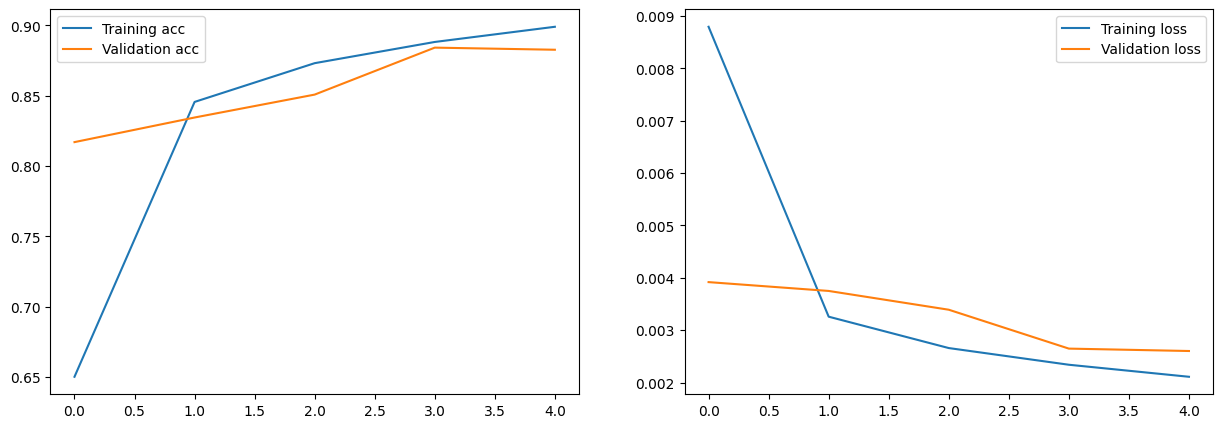

In [14]:
plot_results(hist)

In [15]:
#!wget https://raw.githubusercontent.com/xbresson/CE7454_2019/master/codes/labs_lecture06/lab01_mnist_multilayer/utils.py

In [16]:
import utils

Text(0.5, 1.0, 'label: 2')

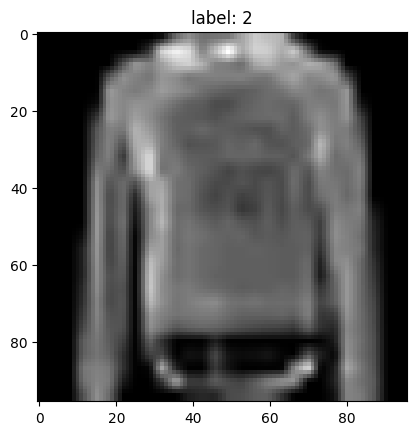

In [17]:
img, label = data_val[np.random.randint(8,21)]
plt.imshow(img.squeeze(), cmap = 'gray')
plt.title(f'label: {label}')

In [18]:
prob = net(img.unsqueeze(0).to('cuda'))
softmax = nn.Softmax()
prob = softmax(prob)
print(prob)

tensor([[2.7745e-04, 1.4485e-05, 9.9463e-01, 1.2384e-05, 6.4174e-04, 1.0365e-07,
         4.4149e-03, 1.0898e-07, 1.1591e-05, 2.0292e-07]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


<ipython-input-18-7fb306ad7e93>:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob = softmax(prob)


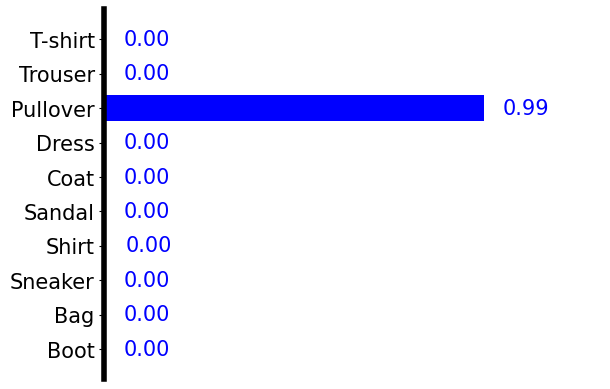

In [19]:
utils.show_prob_fashion_mnist(prob.to('cpu'))